In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(r'C:\Users\Sid\Downloads\archive\Abstract_gallery\Abstract_gallery'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

C:\Users\Sid\Downloads\archive\Abstract_gallery\Abstract_gallery\Abstract_image_0.jpg
C:\Users\Sid\Downloads\archive\Abstract_gallery\Abstract_gallery\Abstract_image_1.jpg
C:\Users\Sid\Downloads\archive\Abstract_gallery\Abstract_gallery\Abstract_image_10.jpg
C:\Users\Sid\Downloads\archive\Abstract_gallery\Abstract_gallery\Abstract_image_100.jpg
C:\Users\Sid\Downloads\archive\Abstract_gallery\Abstract_gallery\Abstract_image_1000.jpg
C:\Users\Sid\Downloads\archive\Abstract_gallery\Abstract_gallery\Abstract_image_1001.jpg
C:\Users\Sid\Downloads\archive\Abstract_gallery\Abstract_gallery\Abstract_image_1002.jpg
C:\Users\Sid\Downloads\archive\Abstract_gallery\Abstract_gallery\Abstract_image_1003.jpg
C:\Users\Sid\Downloads\archive\Abstract_gallery\Abstract_gallery\Abstract_image_1004.jpg
C:\Users\Sid\Downloads\archive\Abstract_gallery\Abstract_gallery\Abstract_image_1005.jpg
C:\Users\Sid\Downloads\archive\Abstract_gallery\Abstract_gallery\Abstract_image_1006.jpg
C:\Users\Sid\Downloads\archive

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch import nn, optim
from matplotlib import pyplot as plt


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'CPU'
print(device)

cuda


In [13]:
path = r'C:\Users\Sid\Downloads\archive\Abstract_gallery'
os.path.exists(path)

True

In [14]:
norm=((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
batch_size = 64
image_size = 64

In [15]:
transf = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(*norm,inplace=True),
])

In [16]:
from torchvision import datasets

dataset = datasets.ImageFolder(root=path,transform=transf)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [10]:
def unnorm(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

In [11]:
def show_batch(data_loader):
    for images, labels in data_loader:
        fig, ax = plt.subplots(figsize=(15, 15))
        ax.set_xticks([]); ax.set_yticks([])
        unnorm_images = unnorm(images, *norm)
        ax.imshow(make_grid(unnorm_images[:batch_size], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

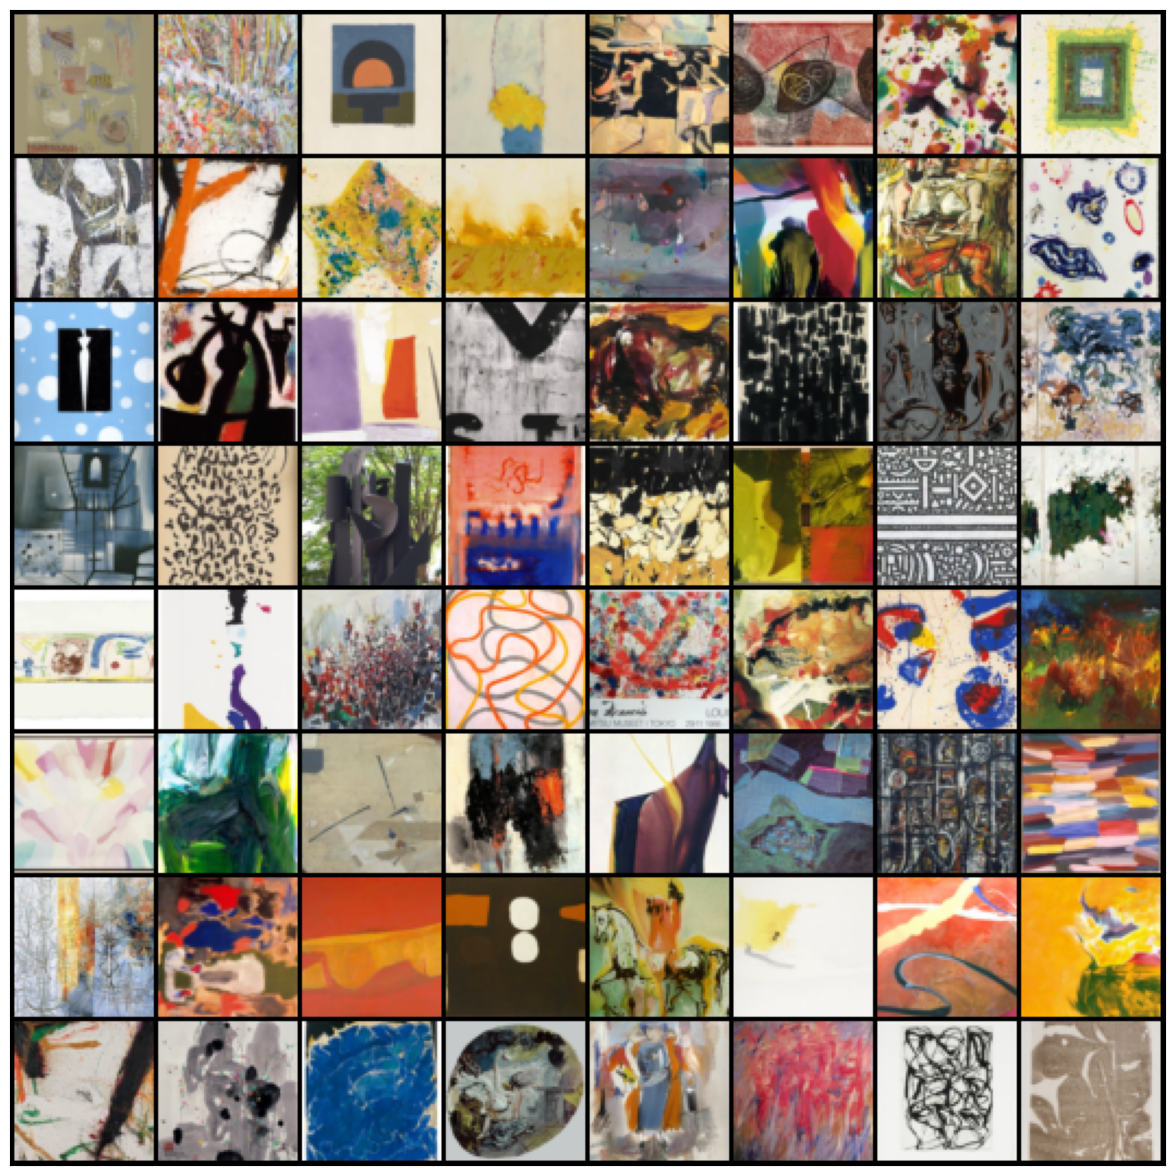

In [17]:
show_batch(dataloader)

In [18]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [19]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1)
    
modelD = Critic()
modelD.to(device)
modelD.apply(weights_init)

Critic(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [20]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

modelG = Generator()
modelG.to(device)
modelG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [21]:
num_epochs = 500

Epoch [1/500], D_loss: -1.4090572595596313, G_loss: 0.687421441078186
Epoch [2/500], D_loss: -1.4227514266967773, G_loss: 0.688880205154419
Epoch [3/500], D_loss: -1.3840315341949463, G_loss: 0.6804088354110718
Epoch [4/500], D_loss: -1.103676199913025, G_loss: 0.40650254487991333
Epoch [5/500], D_loss: -1.4046542644500732, G_loss: 0.6868062615394592
Epoch [6/500], D_loss: -0.9761017560958862, G_loss: 0.7024309039115906
Epoch [7/500], D_loss: -1.4218255281448364, G_loss: 0.6916863918304443
Epoch [8/500], D_loss: -1.3923052549362183, G_loss: 0.6831952333450317
Epoch [9/500], D_loss: -1.3761038780212402, G_loss: 0.6695508360862732
Epoch [10/500], D_loss: -1.2128602266311646, G_loss: 0.6421929001808167
Epoch [11/500], D_loss: -1.4078149795532227, G_loss: 0.685587465763092
Epoch [12/500], D_loss: -1.3906036615371704, G_loss: 0.6823052167892456
Epoch [13/500], D_loss: -1.3765761852264404, G_loss: 0.6682780981063843
Epoch [14/500], D_loss: -1.392103910446167, G_loss: 0.6783273220062256
Epoch

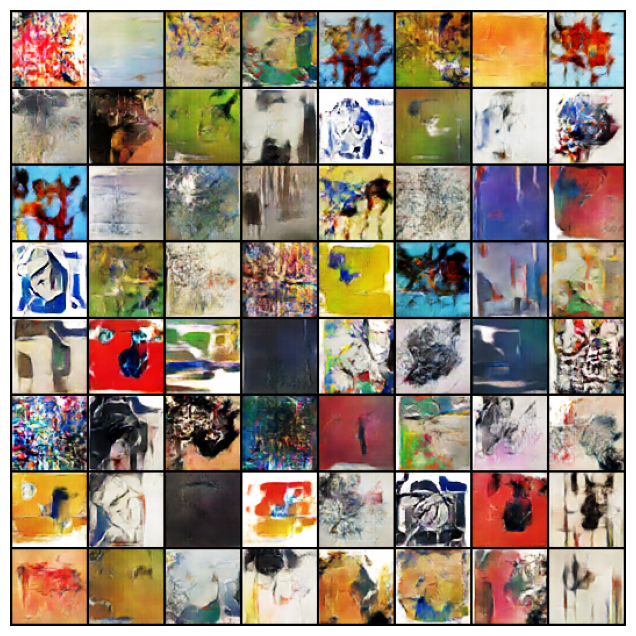

In [24]:
import os
import torch
import torch.optim as optim
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt


def save_samples(generator, latent_tensors, epoch, batch_idx, device, show=True):
    sample_dir = r'C:\Users\Sid\Documents\WGAN'
    os.makedirs(sample_dir, exist_ok=True)
    
    with torch.no_grad():
        generator.eval()
        fake_images = generator(latent_tensors.to(device))
        generator.train()
    
    # Save the images as a grid
    grid = make_grid(fake_images, nrow=8, normalize=True)
    save_path = os.path.join(sample_dir, f"epoch_{epoch}_batch_{batch_idx}.png")
    save_image(grid, save_path)
    
    if show:
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.show()


# Create a fixed latent tensor for consistent comparisons
fixed_latent = torch.randn(64, 100, 1, 1, device=device)

# Your existing optimizer setup
optimizerD = optim.RMSprop(modelD.parameters(), lr=0.00005)
optimizerG = optim.RMSprop(modelG.parameters(), lr=0.00005)

n_critic = 5
clip_value = 0.01
save_interval = 500  # Save images every 500 batches, adjust as needed

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Your existing critic training loop
        for _ in range(n_critic):
            modelD.zero_grad()
            
            real_images = data[0].to(device)
            output_real = modelD(real_images)
            D_loss_real = -torch.mean(output_real)
            
            noise = torch.randn(batch_size, 100, 1, 1, device=device)
            fake_images = modelG(noise)
            output_fake = modelD(fake_images.detach())
            D_loss_fake = torch.mean(output_fake)
            
            D_loss = D_loss_real + D_loss_fake
            D_loss.backward()
            optimizerD.step()
            
            for p in modelD.parameters():
                p.data.clamp_(-clip_value, clip_value)
        
        # Your existing generator training step
        modelG.zero_grad()
        output = modelD(fake_images)
        G_loss = -torch.mean(output)
        G_loss.backward()
        optimizerG.step()
        
        # Save samples periodically
        if i % save_interval == 0:
            save_samples(modelG, fixed_latent, epoch, i, device, show=False)
        
    print(f'Epoch [{epoch+1}/{num_epochs}], D_loss: {D_loss.item()}, G_loss: {G_loss.item()}')

# Save final results after training
save_samples(modelG, fixed_latent, num_epochs, 'final', device, show=True)

In [25]:
torch.save(modelG.state_dict(), 'G.pth')
torch.save(modelD.state_dict(), 'D.pth')